# LSBG Tangential Shear Measurement Analysis

Low surface brightness galaxies (LSBGs) are diffuse galaxies with a surface brightness fainter than the ambient night sky. Given their faintness, the use of traditional astronomical techniques for observation proves challenging. Weak gravitational lensing probes both the baryonic and dark matter content of these galaxies. Weak gravitational lensing averages the shear, or distortion, of thousands of images of background galaxies to extract the distortion caused by the lens object. The large counts of lens-source pairs enable us to find a preferred tangential alignment of source galaxies around lens galaxies: the tangential shear. 

In this notebook, we analyze the LSBG tangential shear measurements obtained with [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html). The LSBG catalog ([Tangolidis et al. 2020](https://arxiv.org/pdf/2006.04294.pdfLSBGs)) divides the LSBG sample into red galaxies at $g-i>0.6$ and blue galaxies at $g-i<0.6$. We plot the tangential shear measurements and perform a series of systematics tests to evaluate their robustness.

## Imports

* We use numpy for numerical calculation and analysis
* We use matplotlib for plotting and visualization

In [1]:
#Loading packages
import matplotlib.pyplot as plt
import numpy as np
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading Data

### Red, Blue, and Total Tangential Shear Measurements 

We load the tangential shear measurements for the red, blue, and total LSBG sample. In addition, we load the tangential shear measurements conducted on the random point sample. 'theta' corresponds to the angular scales of the measurements, 'xi' marks the tangential shear, 'error' represents the shape noise, 'err_jk' indicates the jackknife covariance, and the 'cross term' stands for the shear measured around the lensing B-mode. 

In [37]:
#Loading in measurements
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('../data/gt_LSBG_red', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('../data/gt_LSBG_jackknife_red', unpack=True)

theta_blue, xi_blue, error_blue,  cross_term_blue = np.loadtxt('../data/gt_LSBG_blue', unpack=True)
theta_blue, xi_blue, err_jk_blue, cross_term_blue = np.loadtxt('../data/gt_LSBG_jackknife_blue', unpack=True)

theta, xi, error,  cross_term = np.loadtxt('../data/gt_LSBG_total', unpack=True)
theta, xi, err_jk, cross_term = np.loadtxt('../data/gt_LSBG_jackknife_total', unpack=True)

theta_randoms, xi_randoms, error_randoms, err_jk_randoms = np.loadtxt('../data/gt_LSBG_randoms', unpack=True)



### Covariance Matrices

We load the jackknife covariance matrices for the total, red, and blue LSBG samples. In addition, we load in the covariance matrices for the random sample and the $\gamma _\times$ term, or the lensing B-mode term.

In [43]:
#Loading in covariances
cov = np.loadtxt('../data/gt_jkcov')
cov_red = np.loadtxt('../data/gt_jkcov_red')
cov_blue = np.loadtxt('../data/gt_jkcov_blue')
randoms_cov = np.loadtxt('../data/gt_jkcov_randoms')
cross_term_cov = np.loadtxt('../data/gx_jkcov')
cross_term_cov_red = np.loadtxt('../data/gx_jkcov_red')
cross_term_cov_blue = np.loadtxt('../data/gx_jkcov_blue')


### Boost Factor Measurements

We load the boost factors, derived from the tangential shear measurements, and the boost factor covariance matrices. The boost factor measures the excess number of sources around lenses compared to the amount of sources around random points. We use the boost factor to quantify bias caused by lens-source clustering.

In [4]:
#Loading in boost factor
boost_factor_red = np.loadtxt('../data/boost_factor_red')
boost_factor_blue = np.loadtxt('../data/boost_factor_blue')


In [5]:
#Loading boost factor covariances
boost_factor_red_cov = np.loadtxt('../data/boost_factor_jkcov_red')
boost_factor_blue_cov = np.loadtxt('../data/boost_factor_jkcov_blue')

## Function Definitions

### Measurement Quality Functions

We define the functions used to evaluate the strength of the measurements

We define two iterations of the $\chi^2$ statistic, used to determine the quality of the fit between a model and a dataset or between two models. We define the $\chi^2$ statistic as: $$\chi^2 = (\gamma_{t, d}-\gamma_{t,m})\times \mathrm{C}^{-1}\times (\gamma_{t,d}-\gamma_{t,m}), $$ where $\gamma_{t,d}$ represents the measurements, $\mathrm{C}$ is the covariance, and $\gamma_{t,m}$ indicates the model. 

We calculate the $\chi^2_\mathrm{null}$ to assess the strength of the lensing signal. The $\chi^2_\mathrm{null}$ compares the lensing signal to a null model, as follows: $$\chi^2_\mathrm{null} = \gamma_{t,d}\times \mathrm{C}^{-1}\times \gamma_{t, d}.$$ 


The $\chi^2$ statistic depends on the jackknife covariance, but the inverse of this matrix is biased and noisy. We correct for this bias by using the Hartlap-Kaufman factor ([Hartlap et al. 2007](https://arxiv.org/pdf/astro-ph/0608064.pdf)). The Hartlap-Kaufman factor scales the inverse of the covariance matrix by: $$f = (n-m-2)/(n-1),$$ with $n$ as the number of realizations (100, for our jackknife patches) and $m$ as the number of entries in the data vectors (22, for the number of angular bins). 

In [6]:
def hartlap(n=None, m=None):
    """
    Calculates the Hartlap-Kaufman factor
    
    n = number of realizations (in our case 100)
    m = number of data entries (in our case 22)
    
    Returns: Hartlap-Kaufman factor
    """
    hartlap_factor = (n - m -2)/ float(n-1)
    return hartlap_factor

In [7]:
def chi2(cov=None, model=None, measurements=None, n=None, m=None):
    """
    Calculates chi^2 between model and measurements
    
    cov = covariance matrix
    model = model of choice
    measurements = measurement of choice
    
    Returns: chi2 between shear measurements and model
    """
    invcov = (np.linalg.inv(cov))
    chi2_bias = np.dot((measurements-model), np.dot(invcov, (measurements-model)))
    hartlap_factor = hartlap(n=n, m=m)
    chi2 = chi2_bias*hartlap_factor
    return chi2

In [8]:
def chi2_null(cov=None, measurements=None, n=None, m=None):
    """
    Calculates chi^2 between measurements and null signal to evaluate signal strength
    
    cov = covariance matrix
    measurements = measurements
    
    Returns: chi2 between shear measurements and a null model
    """
    invcov = (np.linalg.inv(cov))
    chi2_bias = np.dot(np.dot((measurements), invcov), (measurements.T))
    hartlap_factor = hartlap(n=n, m=m)
    chi2 = chi2_bias*hartlap_factor
    return chi2

In [9]:
def deltachi2(cov=None, model_1=None, model_2=None, n=None, m=None):
    """
    Calculates the delta chi2, the quantifiable difference between two models
    
    cov = jackknife covariance matrix
    model1 = first model
    model2 = second model
    n = number of realizations 
    m = number of data entries
    
    Returns: delta chi2 between models
    """
    invcov = np.linalg.inv(cov)
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model_1).T[0]-(model_2).T[0])
    deltachi2_bias = diff*INVCOV*diff.T
    hartlap_factor = hartlap(n=n, m=m)
    deltachi2 = deltachi2_bias*hartlap_factor
    
    return deltachi2

We define a function to calculate the signal-to-noise (S/N) of the measurements, incorporating the $\chi^2_\mathrm{null}$, the hartlap factor, and the number of degrees of freedom $(\nu)$. The S/N values are defined as: $$\mathrm{S/N} = \sqrt{(\chi^2_\mathrm{null}*f) - \nu}. $$

In [10]:
def sn(dof=None, cov=None, measurements=None, n=None, m=None):
    """
    Calculates the signal-to-noise
    
    dof = number of degrees of freedom (in our case 22)
    cov = covariance matrix
    measurements = measurements
    n=number of realizations
    m = number of data entries
    
    Returns: signal-to-noise
    """
    chi2 = chi2_null(cov=cov, measurements=measurements, n=n, m=m)
    sn = np.sqrt(chi2-dof)
    return sn

We define a function that constructs the correlation matrix for a given covariance.

In [11]:
def corrmatrix(cov=None):
    """
    Calculates the correlation matrix
    
    cov=covariance matrix
    
    Returns: correlation matrix
    """
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

We define a function to calculate errorbars based on the jackknife covariance (if errorbars have not been provided by [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)). 

In [12]:
def errorbar(cov=None):
    """
    Calculates the errorbars based on the jackknife covariance
    
    cov = jackknife covariance matrix
    
    Returns: errorbars 
    """
    err_jk = np.sqrt(np.diag(cov))
    return err_jk

### Visualization Functions

We define functions to plot the tangential shear measurements, the $\gamma_{\times}$ term, the random sample shear measurements, the covariance diagonals, and the covariance correlation matrices. 

We define a function that plots the tangential shear measurements (xi) across angular scales of 0.25-400 arcmin (theta) in 22 angular bins. The errorbars are derived from the jackknife covariance. 

In [38]:
def plot_tangential_shear(theta=None, xi=None, err_jk=None, color=None, galaxy_type=None):
    """
    Plots the tangential shear measurements across angular scales
    
    theta = angular scales [arcmin]
    xi = tangential shear signal 
    err_jk = jackknife errorbars
    color = color of plot (should match galaxy type, black for total)
    galaxy type = color type of galaxy (red, blue, or total)
    
    Returns: plot of tangential shear measurements
    """
    fig = plt.figure(figsize=(6,4.5))
    for i in range(len(theta)):
        if xi[i]>0:
            plt.errorbar(theta, xi, err_jk, fmt="o", color=color)
        if xi[i]<=0:
            plt.errorbar(theta, -1*xi, err_jk, fmt="v", color=color)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("$\\theta$ [arcmin]", fontsize=16)
    plt.ylabel("$\gamma_t(\\theta)$", fontsize=16)
    plt.ylim(10**(-6),  3*10**(-2))
    plt.title('$\gamma_t$', fontsize=16)
    plt.legend(frameon=False, fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

We define functions that plot the shear measurements of the $\gamma_{\times}$ term and the shear measurements of the randoms sample. 

The tangential shear measures the distortion of the lensing E-mode, while the $\gamma_{\times}$ term measures the distortion of the lensing B-mode. Weak lensing only produces a tangential shear, thus in the absence of additional systematics the $\gamma_{\times}$ term remains consistent with zero. 

The function calculates the errorbars for the $\gamma_{\times}$ (cross_term) based on the measured $\gamma_{\times}$ covariance. It plots $\gamma_{\times} \times \theta$ over the binned angular separations (theta).

As an additional systematics test, we plot the tangential shear around the randoms sample. These points are randomly selected, thus we should measure no lensing signal. 

In [27]:
def plot_cross_term(theta=None, cross_term_arr=None, cross_term_cov_arr=None):
    """
    Plots the cross term shear
    
    theta = angular separations
    cross_term = lensing B-mode shear
    cross_term_cov = covariance of lensing B-mode shear
    
    Returns: plot of cross term shear measurements
    """
    fig = plt.figure(figsize=(6, 4.5))
    cross_term_err_jk_red = errorbar(cov=cross_term_cov_arr[0])
    cross_term_err_jk_blue = errorbar(cov=cross_term_cov_arr[1])
    plt.errorbar(theta, cross_term_arr[0]*theta, cross_term_err_jk_red*theta, fmt='o', color="firebrick", label='Red LSBGs')
    plt.errorbar(theta*1.15, cross_term_arr[1]*theta, cross_term_err_jk_blue*theta, fmt='o', color="royalblue", label='Blue LSBGs')
    plt.ylabel('$\gamma_\\times \\times \\theta$', fontsize=16)
    plt.ylim(-0.006, 0.006)
    plt.xlabel("$\\theta$ [arcmin]", fontsize=16)
    plt.axhline(y=0, ls = ':' , color = 'k' )
    plt.xscale('log')
    plt.tick_params(axis='both', labelsize=14)
    plt.title('$\gamma_x$', fontsize=16)
    plt.legend(frameon=False, fontsize=16, loc='upper left')
    plt.show()


In [49]:
def plot_ran_shear(theta_randoms=None, xi_randoms=None, err_jk_randoms=None):
    """
    Plots the shear measured around the randoms sample compared to the lensing signal
    
    theta_randoms = randoms sample angular separations
    xi_randoms = randoms sample shear measurements
    err_jk_randoms = randoms sample errorbars
    
    Returns: plot of random shear measurements
    """
    fig = plt.figure(figsize=(6,4.5))
    plt.errorbar(theta_randoms, xi_randoms, err_jk_randoms, fmt="o", color="black", label = 'Random Signal')
    plt.errorbar(theta_red*1.15, np.abs(xi_red), err_jk_red, fmt="x", color = 'firebrick', label='Red Signal')
    plt.errorbar(theta_blue*1.15, np.abs(xi_blue), err_jk_blue, fmt="x", color = 'royalblue', label='Blue Signal')
    plt.ylabel('$\gamma_t(\\theta)$', fontsize=16)
    plt.ylim(-0.00015, 0.00015)
    plt.xlabel("$\\theta$ [arcmin]", fontsize=16)
    plt.axhline(y=0, ls = ':' , color = 'k' )
    plt.xscale('log')
    plt.legend(frameon=False, loc='lower right', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.title('Randoms $\gamma_t$', fontsize=16)
    plt.show()

We define a function to plot the correlation matrices for the jacknife covariance matrix. 

In [16]:
def plot_cov(cov=None, size=None, colormap=None):
    """
    Plots the correlation matrix for the covariance
    
    cov = covariance matrix
    size = size of figure
    colormap = colormap of matrix
    
    Return: plot of jackknife covariance correlation matrix 
    """
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1., cmap=str(colormap))
    plt.colorbar(im, ax=ax)
    plt.show()

### Boost Factor Functions

The tangential shear measurements ignore the clustering between lens and source galaxies, which at small angular scales can change the number of lens-source pairs compared to predictions based on the mean number densities. This effect biases the shear estimator. To estimate the decrease in lensing signal caused by lens-source clustering, we compare the excess number of sources around lenses to the number of sources surrounding random points as a function of scale. We define the resulting measurement as the boost factor ([Sheldon et al.2004](https://arxiv.org/pdf/astro-ph/0312036.pdf)).

We define a function to plot the boost factor for the red and blue galaxy samples. The boost factors and covariances for the assorted color samples must be converted into arrays. 

In [17]:
def boost_plot(theta_boost_arr=None, boost_factor_arr=None, boost_factor_cov_arr=None, color_arr_boost=None, boost_factor_label_arr=None):
    """
    Plots the red and blue LSBG boost factor measurements, with errorbars from the jackknifce covariance
    
    theta_boost_arr = array of theta, theta*1.15 for better visibility
    boost_factor_arr = array of red and blue boost factors
    boost_factor_cov_arr = array of red and blue boost factor covariances
    color_arr_boost = array of colors for plot
    
    Returns: plot of red and blue LSBG boost factors
    """
    err_jk_boost_list =[]
    fig = plt.figure(figsize=(6,4.5))
    for i in range(len(boost_factor_arr)):
        err_jk_boost = errorbar(boost_factor_cov_arr[i])
        plt.errorbar(theta_boost_arr[i], boost_factor_arr[i], err_jk_boost, fmt="o", 
                     color = color_arr_boost[i], label=boost_factor_label_arr[i])
    plt.xscale('log')
    plt.xlabel('$\\theta$ [arcmin]',fontsize=16)
    plt.ylabel('$B(\\theta)$', fontsize=16)
    plt.axhline(y=1.0, ls = ':' , color = 'k' )
    plt.tick_params(axis='both', labelsize=14)
    plt.legend(frameon=False, fontsize=16, loc='lower right')
    plt.title('Boost Factor', fontsize=16)
    plt.show()

## Defining Parameters 

We define the extra parameters for the Hartlap-Kaufman factor and the signal-to-noise, where $n$ designates the number of realizations, $m$ indicates the number of data entries, and dof represents the degrees of freedom.

In [18]:
n = 100
m = 22
dof = 22

We establish arrays of angular separations, shape noise, jackknife diagonals, and colors for the *noise_diag* function. 

In [19]:
theta_arr = np.array([theta, theta_red, theta_blue])
error_arr = np.array([error, error_red, error_blue])
err_jk_arr = np.array([err_jk, err_jk_red, err_jk_blue])
color_arr = np.array(['black', 'firebrick', 'royalblue'])

We establish arrays of angular separations, shear measurements, and covariances for the *plot_cross_term* function.

In [20]:
cross_term_arr = np.array([cross_term_red, cross_term_blue])
cross_term_cov_arr = np.array([cross_term_cov_red, cross_term_cov_blue])

We establish arrays of boost factors, boost factor covariances, and colors for the *boost_plot* function. 

In [21]:
theta_boost_arr = np.array([theta, theta*1.15])
boost_factor_arr = np.array([boost_factor_red, boost_factor_blue])
boost_factor_cov_arr = np.array([boost_factor_red_cov, boost_factor_blue_cov])
color_arr_boost = np.array(['firebrick', 'royalblue'])
boost_factor_label_arr = np.array(['Boost Factor, Red LSBGs', 'Boost Factor, Blue LSBGs'])

## Measurement Evaluations

We call the functions to plot the tangential shear measurements for the red, blue, and total sample of LSBGs. Note that the triangle markings indicate that the selected shear measurement is negative.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


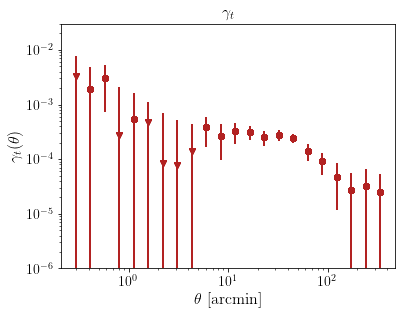

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


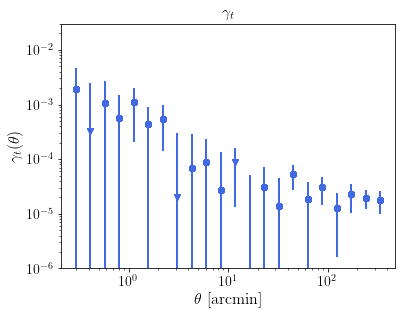

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


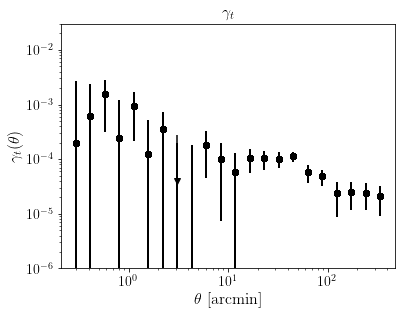

In [39]:
plot_tangential_shear(theta_red, xi_red, err_jk_red, "firebrick", "Red")
plot_tangential_shear(theta_blue, xi_blue, err_jk_blue, "royalblue", "Blue")
plot_tangential_shear(theta, xi, err_jk, "black", "Total")

We calculate the $\chi^2_\mathrm{null}$ and the signal-to-noise for the total sample, red LSBG sample, and blue LSBG sample.

In [44]:
chi2_total = chi2_null(cov=cov, measurements=xi, n=n, m=m)
sn_total = sn(n=n, m=m, dof=dof, cov=cov, measurements=xi)
print(chi2_total, sn_total)

50.09624659222689 5.30058926839525


In [45]:
chi2_red = chi2_null(cov=cov_red, measurements=xi_red, n=n, m=m)
sn_red = sn(n=n, m=m, dof=dof, cov=cov_red, measurements=xi_red)
print(chi2_red, sn_red)

66.42409585545164 6.665140347768503


In [46]:
chi2_blue = chi2_null(cov=cov_blue, measurements=xi_blue, n=n, m=m)
sn_blue = sn(n=n, m=m, dof=dof, cov=cov_blue, measurements=xi_blue)
print(chi2_blue, sn_blue)

26.69542735014794 2.1668934791881074


## Systematics Evaluations

We plot the $\gamma_{\times}$ term and calculate the $\chi^2$. Note that we do not produce a measurable signal for the $\gamma_{\times}$ term. We include an offset in $\theta$ to improve the visibility of the measurements. 

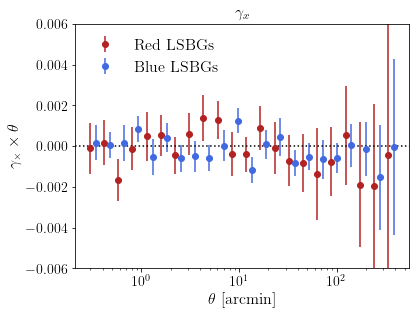

In [28]:
plot_cross_term(theta=theta, cross_term_arr=cross_term_arr, cross_term_cov_arr=cross_term_cov_arr)

In [29]:
chi2_cross_term = chi2_null(cov=cross_term_cov, measurements=cross_term, n=n, m=m)
sn_cross_term = sn(n=n, m=m, dof=dof, cov=cross_term_cov, measurements=cross_term)
print(chi2_cross_term, sn_cross_term)

13.579812600693838 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_87596/547123592.py:14: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


In [30]:
chi2_cross_term_red = chi2_null(cov=cross_term_cov_red, measurements=cross_term_red, n=n, m=m)
sn_cross_term_red = sn(n=n, m=m, dof=dof, cov=cross_term_cov_red, measurements=cross_term_red)
print(chi2_cross_term_red, sn_cross_term_red)

14.842226019461867 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_87596/547123592.py:14: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


In [31]:
chi2_cross_term_blue = chi2_null(cov=cross_term_cov_blue, measurements=cross_term_blue, n=n, m=m)
sn_cross_term_blue = sn(n=n, m=m, dof=dof, cov=cross_term_cov_blue, measurements=cross_term_blue)
print(chi2_cross_term_blue, sn_cross_term_blue)

15.956030595228226 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_87596/547123592.py:14: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


We call the function to plot the shear of the randoms sample and calculate the $\chi^2$. Note that we do not produce a measurable signal for the randoms term, confirming our expectations.

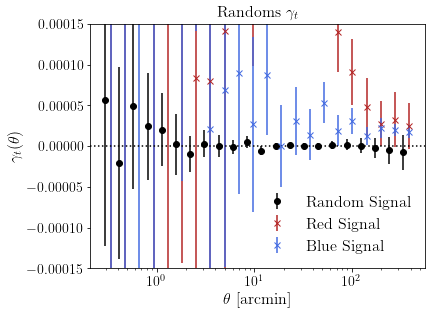

In [50]:
plot_ran_shear(theta_randoms=theta_randoms, xi_randoms=xi_randoms, err_jk_randoms=err_jk_randoms)

In [51]:
chi2_randoms = chi2_null(cov=randoms_cov, measurements=xi_randoms, n=n, m=m)
sn_randoms = sn(n=n, m=m, dof=dof, cov=randoms_cov, measurements=xi_randoms)
print(chi2_randoms, sn_randoms)

3.2121370063944616 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_87596/547123592.py:14: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


We plot the correlation matrices for the jackknife covariance of the red LSBGs and blue LSBGs. The *x* and *y* axes correspond to the angular bins of the tangential shear measurements. At larger scales (bins>14), the correlation between bins grows stronger.

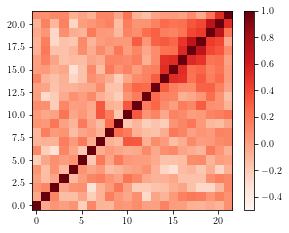

In [34]:
plot_cov(cov=cov_red, size=6, colormap='Reds')

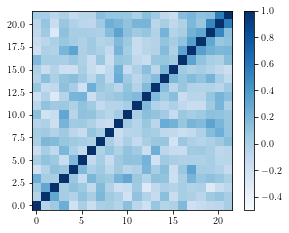

In [35]:
plot_cov(cov=cov_blue, size=6, colormap='Blues')

## Boost Factor Evaluation

We call the functions to plot the boost factors for the red and blue LSBG samples and calculate the $\chi^2$. The errorbars come from the jackknife covariance. The boost factor measurements are highly correlated and consistent with 1 for both red and blue galaxies. The increased size of the red galaxy errorbars stems from the larger spatial variation between the red galaxy positions in the DES footprint.

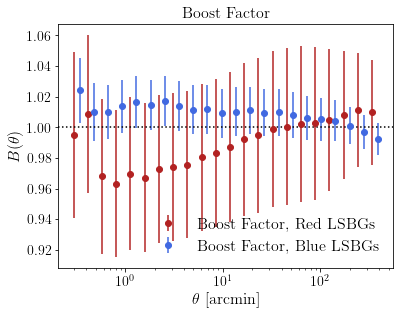

In [36]:
boost_plot(theta_boost_arr=theta_boost_arr, boost_factor_arr=boost_factor_arr, boost_factor_cov_arr=boost_factor_cov_arr, color_arr_boost=color_arr_boost, boost_factor_label_arr=boost_factor_label_arr)
